# submission annum base 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Set global seed
np.random.seed(578)

def load_docs_and_labels(paths):
    docs = []
    labels = []
    for path in paths:
        with open(path, encoding="utf-8") as f:
            content = f.read().strip()
            docs.append(content)
        filename = os.path.basename(path)
        label = os.path.splitext(filename)[0]  
        labels.append(label)
    return docs, labels

# Load data
train_paths = glob.glob("math/train-medium/*.txt")
inter_paths = glob.glob("math/interpolate/*.txt")
extra_paths = glob.glob("math/extrapolate/*.txt")

train_docs, train_labels = load_docs_and_labels(train_paths)
inter_docs, inter_labels = load_docs_and_labels(inter_paths)
extra_docs, extra_labels = load_docs_and_labels(extra_paths)

print("Train docs:", len(train_docs))
print("Interpolate docs:", len(inter_docs))
print("Extrapolate docs:", len(extra_docs))

# TF-IDF + n-grams
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_docs)

# Fit train set to validate/test set labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)

# test/validate sets to known classes
train_classes = set(le.classes_)
inter_filtered = [(doc, lbl) for doc, lbl in zip(inter_docs, inter_labels) if lbl in train_classes]
extra_filtered = [(doc, lbl) for doc, lbl in zip(extra_docs, extra_labels) if lbl in train_classes]

inter_docs_filt, inter_labels_filt = zip(*inter_filtered) if inter_filtered else ([], [])
extra_docs_filt, extra_labels_filt = zip(*extra_filtered) if extra_filtered else ([], [])

# Embeddings
X_inter = vectorizer.transform(inter_docs_filt)
X_extra = vectorizer.transform(extra_docs_filt)

y_inter = le.transform(inter_labels_filt)
y_extra = le.transform(extra_labels_filt)

# Mappinb categorical features
fine_to_coarse = {lbl: lbl.split("__")[0] for lbl in le.classes_}

coarse_train_labels = [fine_to_coarse[lbl] for lbl in le.inverse_transform(y_train)]
coarse_inter_labels = [fine_to_coarse[lbl] for lbl in le.inverse_transform(y_inter)]
coarse_extra_labels = [fine_to_coarse[lbl] for lbl in le.inverse_transform(y_extra)]

le_coarse = LabelEncoder()
y_train_coarse = le_coarse.fit_transform(coarse_train_labels)
y_inter_coarse = le_coarse.transform(coarse_inter_labels)
y_extra_coarse = le_coarse.transform(coarse_extra_labels)

# Fit model on coarse categorical features
clf = LogisticRegression(max_iter=5000, random_state=578)
clf.fit(X_train, y_train_coarse)

# Evaluate interpolate
print("\nCoarse category-level report on interpolate set:")
print(classification_report(y_inter_coarse, clf.predict(X_inter), labels=range(len(le_coarse.classes_)), target_names=le_coarse.classes_, zero_division=0))

# Evaluate extrapolate
print("\nCoarse category-level report on extrapolate set:")
print(classification_report(y_extra_coarse, clf.predict(X_extra), labels=range(len(le_coarse.classes_)), target_names=le_coarse.classes_, zero_division=0))

# ---- Fine-grained block for eda (commented out for further research in the space) ----
"""
print("\nFine-grained classification report on interpolate set:")
print(classification_report(y_inter, clf.predict(X_inter), labels=range(len(le.classes_)), target_names=le.classes_, zero_division=0))

print("\nFine-grained classification report on extrapolate set:")
print(classification_report(y_extra, clf.predict(X_extra), labels=range(len(le.classes_)), target_names=le.classes_, zero_division=0))
"""

# ---- Shape summary ----
print("\nFinal shape summary:")
print("Train X:", X_train.shape, "Train y:", y_train_coarse.shape)
print("Interpolate X:", X_inter.shape, "Interpolate y:", y_inter_coarse.shape)
print("Extrapolate X:", X_extra.shape, "Extrapolate y:", y_extra_coarse.shape)

# Compact label preview
print("\nLabel classes preview (first 10):", list(le.classes_)[:10], "...")
print("Total fine-grained classes:", len(le.classes_))
print("Coarse category classes:", list(le_coarse.classes_))

Train docs: 56
Interpolate docs: 56
Extrapolate docs: 15

Coarse category-level report on interpolate set:
              precision    recall  f1-score   support

     algebra       1.00      1.00      1.00         8
  arithmetic       1.00      0.78      0.88         9
    calculus       0.00      0.00      0.00         2
  comparison       1.00      0.88      0.93         8
 measurement       0.00      0.00      0.00         2
     numbers       0.65      1.00      0.79        17
 polynomials       1.00      1.00      1.00         8
 probability       0.00      0.00      0.00         2

    accuracy                           0.84        56
   macro avg       0.58      0.58      0.57        56
weighted avg       0.79      0.84      0.80        56


Coarse category-level report on extrapolate set:
              precision    recall  f1-score   support

     algebra       0.00      0.00      0.00       0.0
  arithmetic       0.00      0.00      0.00       0.0
    calculus       0.00      

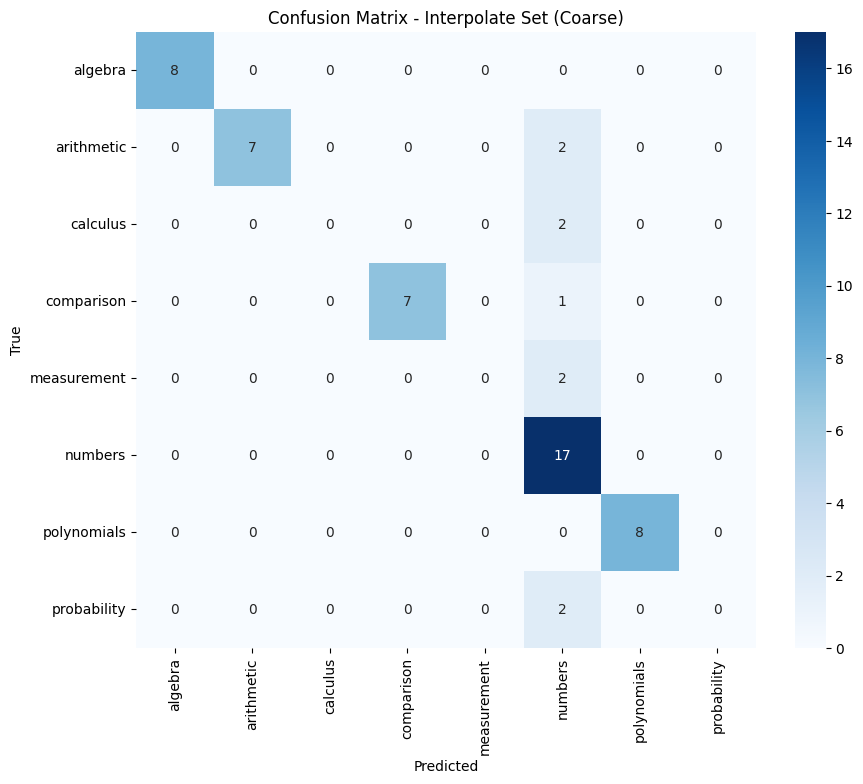

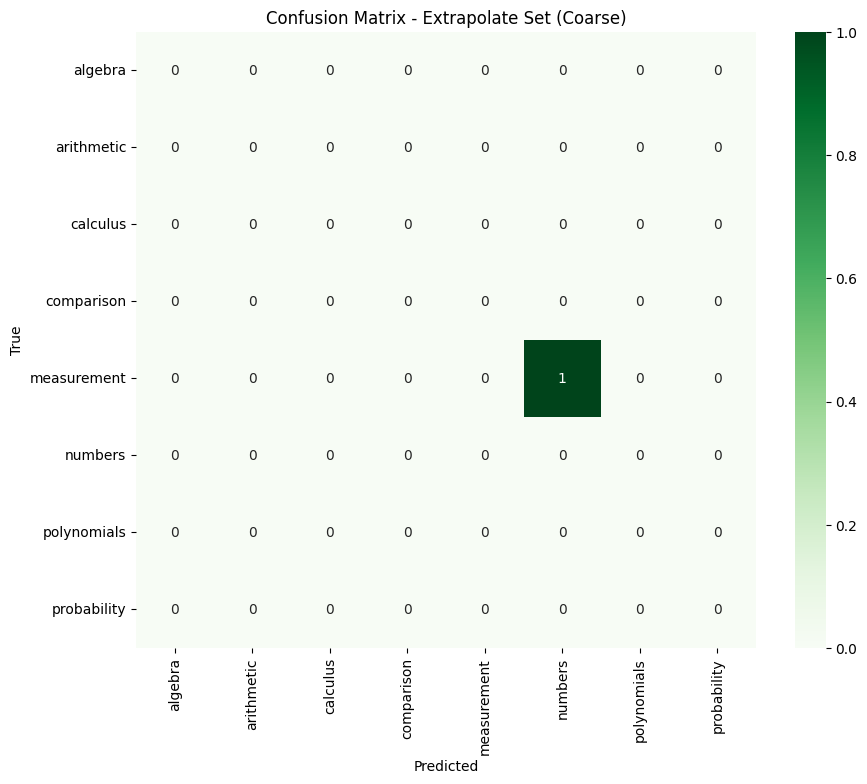

```

## Logistic Regression Model Summary

- Max iterations: 5000
- Random state: 578
- Number of coarse classes: 8
- Feature space size (TF-IDF): 10000

```

In [2]:
# ---- Visuals: Confusion matrices ----
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Interpolate
y_pred_inter_coarse = clf.predict(X_inter)
cm_inter_coarse = confusion_matrix(y_inter_coarse, y_pred_inter_coarse, labels=range(len(le_coarse.classes_)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_inter_coarse, annot=True, fmt='d', cmap="Blues", xticklabels=le_coarse.classes_, yticklabels=le_coarse.classes_)
plt.title("Confusion Matrix - Interpolate Set (Coarse)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Extrapolate
y_pred_extra_coarse = clf.predict(X_extra)
cm_extra_coarse = confusion_matrix(y_extra_coarse, y_pred_extra_coarse, labels=range(len(le_coarse.classes_)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_extra_coarse, annot=True, fmt='d', cmap="Greens", xticklabels=le_coarse.classes_, yticklabels=le_coarse.classes_)
plt.title("Confusion Matrix - Extrapolate Set (Coarse)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---- Markdown summary display ----
from IPython.display import Markdown, display

summary_text = f"""
## Logistic Regression Model Summary

- Max iterations: {clf.max_iter}
- Random state: {clf.random_state}
- Number of coarse classes: {len(le_coarse.classes_)}
- Feature space size (TF-IDF): {X_train.shape[1]}
"""

display(Markdown(f"```\n{summary_text}\n```"))

In [3]:
from sklearn.metrics import log_loss

# Probabilities on interpolate
y_proba_inter = clf.predict_proba(X_inter)
logloss_inter = log_loss(y_inter_coarse, y_proba_inter, labels=range(len(le_coarse.classes_)))
print("Log loss (interpolate set):", logloss_inter)

# Probabilities on extrapolate
y_proba_extra = clf.predict_proba(X_extra)
logloss_extra = log_loss(y_extra_coarse, y_proba_extra, labels=range(len(le_coarse.classes_)))
print("Log loss (extrapolate set):", logloss_extra)

Log loss (interpolate set): 1.0163876890058137
Log loss (extrapolate set): 2.2753941450515796


In [4]:
from scipy.stats import entropy

# Interpolate
entropies_inter = [entropy(p) for p in y_proba_inter]
print("Interpolate prediction entropy stats: mean", np.mean(entropies_inter), "std", np.std(entropies_inter))

# Extrapolate
entropies_extra = [entropy(p) for p in y_proba_extra]
print("Extrapolate prediction entropy stats: mean", np.mean(entropies_extra), "std", np.std(entropies_extra))

Interpolate prediction entropy stats: mean 1.693077773726014 std 0.1583189405403394
Extrapolate prediction entropy stats: mean 1.9306218983394217 std 0.0


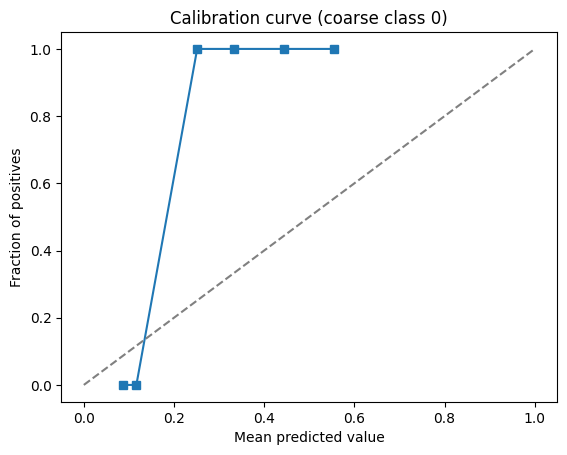

In [5]:
from sklearn.calibration import calibration_curve

# Example for interpolate set, binary version if you want to test one-vs-all
# Here, for illustrative purposes, let's pick first class

prob_class0 = y_proba_inter[:, 0]
true_class0 = (y_inter_coarse == 0).astype(int)

fraction_of_positives, mean_predicted_value = calibration_curve(true_class0, prob_class0, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve (coarse class 0)")
plt.show()

In [6]:
import pandas as pd

# Check variance on predictions
df_proba_inter = pd.DataFrame(y_proba_inter, columns=le_coarse.classes_)
variances = df_proba_inter.var(axis=0)
print("Class-wise prediction variances (interpolate set):")
print(variances)

Class-wise prediction variances (interpolate set):
algebra        0.013664
arithmetic     0.013563
calculus       0.000679
comparison     0.006702
measurement    0.000326
numbers        0.024003
polynomials    0.006314
probability    0.000819
dtype: float64


In [ ]:
# End of base model builds and test